# Tutorial: Intrinsic dimension, Density estimation and Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from duly import data
from duly.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline


In [2]:
#ls

In [3]:

# import a test set
X = np.genfromtxt('datasets/Fig1.dat')[:15000]

print(X.shape)
# X = np.genfromtxt('Fig2.dat')

# X = np.genfromtxt('FigS1.dat')
# X = np.genfromtxt('FigS2.dat')

# X = np.genfromtxt('FigS3.dat')

#X = np.genfromtxt('FigS4.dat')ls


(15000, 2)


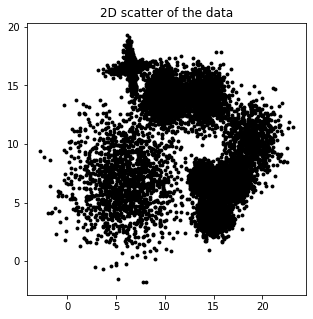

In [4]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

In [5]:
# initialise the Data class
_data = data.Data(X)


In [6]:
# compute distances up to the maxk NN
_data.compute_distances(maxk = 1000, njobs = 1)

Computation of the distances up to 1000 NNs started
Computation of the distances finished


In [7]:
_data.maxk

1000

In [8]:
# estimate ID
_data.compute_id_2NN()

ID estimation finished: selecting ID of 2.01


In [9]:
# estimate ID Bayesian
#_data.compute_id_gammaprior(alpha = 2, beta = 2)

In [10]:
# estimate density with k-NN
#_data.compute_density_kNN(k = 30)

In [11]:
_data.compute_density_kstarNN()

kstar estimation started, Dthr = 23.92812698
15.31 seconds finding the optimal k for all the points
kstar-NN density estimation started
k-NN density estimation finished


In [12]:
# estimate density with PAk using cython implementation of Newton-Raphson minimisation
#_data.compute_density_PAk()

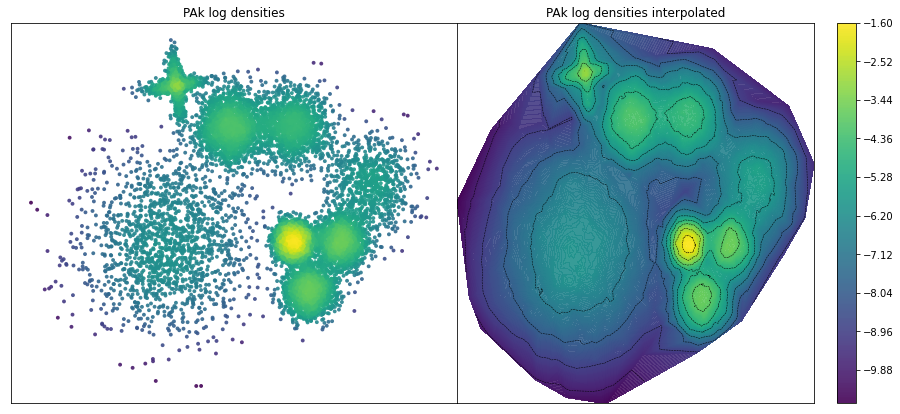

In [13]:
f, [ax1 ,ax2] = plt.subplots(1, 2, figsize = (16, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.set_title('PAk log densities')

ax1.scatter(X[:,0],X[:,1],s=15.,alpha=0.9, c = _data.Rho,linewidths=0.0)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.set_title('PAk log densities interpolated')
ax2.tricontour(X[:,0],X[:,1],_data.Rho,levels=10, linewidths=0.5, colors='k')
fig2=ax2.tricontourf(X[:,0],X[:,1],_data.Rho,levels=250,alpha=0.9)

plt.colorbar(fig2)
plt.show()

In [14]:
# estimate clusters
_data.compute_clustering_optimised(Z = 1.65, halo=True)

Clustering started
('Number of clusters before multimodality test=', 8)
0.05 seconds clustering before multimodality test
0.00 seconds identifying the borders
0.00 seconds with multimodality test
0.00 seconds for final operatins
Clustering finished, 8 clusters found
total time is, 0.0818326473236084


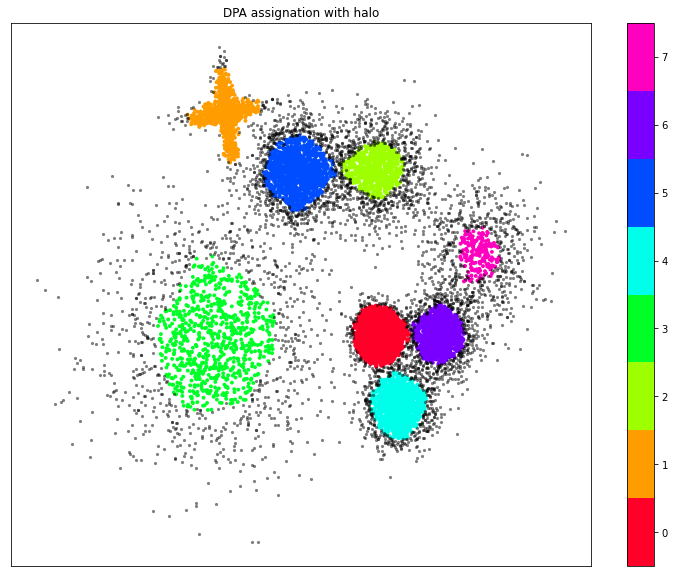

In [15]:

Nclus_m=len(_data.centers_m) 
cmap = plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DPA assignation with halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(_data.labels)):
    if (_data.labels[j]!=-1):
        xdtmp.append(_data.X[j,0]) 
        ydtmp.append(_data.X[j,1])
        ldtmp.append(_data.labels[j])
    else:
        xntmp.append(_data.X[j,0])
        yntmp.append(_data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)

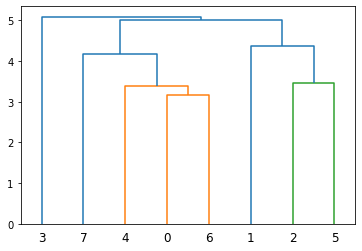

In [16]:
# plot dendogram
plot_SLAn(_data)

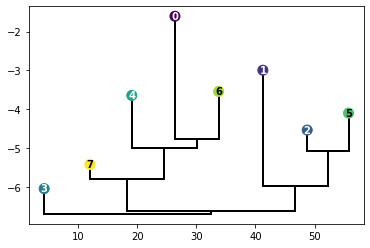

In [17]:
get_dendrogram(_data)

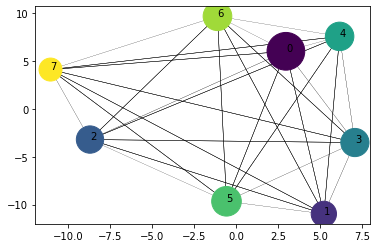

In [18]:
# plot graph of clusters
plot_MDS(_data)

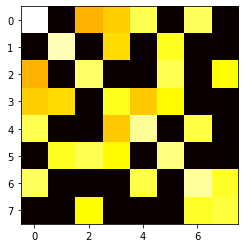

In [19]:
# plot connectivity matrix
plot_matrix(_data)


# Classical DP clustering with the density computed with DULY

Number of points for which self.delta needed call to cdist= 6


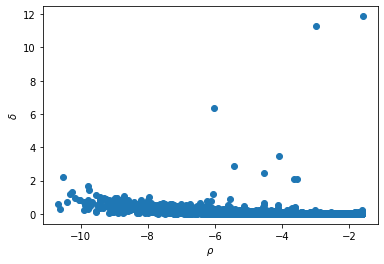

In [23]:
_data.compute_DecGraph()

In [24]:
_data.compute_cluster_DP(dens_cut=-7,delta_cut=1.75, halo=False)

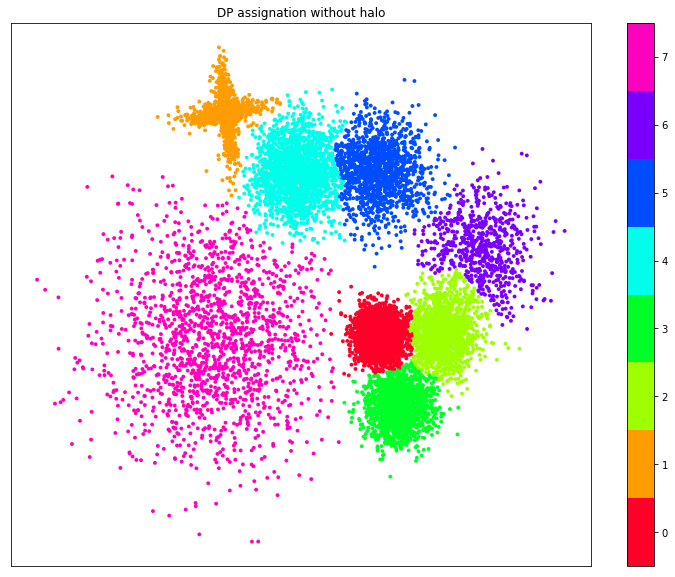

In [25]:
Nclus_m=np.max(_data.labels)+1 
cmap = plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DP assignation without halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(_data.labels)):
    if (_data.labels[j]!=-1):
        xdtmp.append(_data.X[j,0]) 
        ydtmp.append(_data.X[j,1])
        ldtmp.append(_data.labels[j])
    else:
        xntmp.append(_data.X[j,0])
        yntmp.append(_data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)